# 🎬 StreamPulse AI – Predicting Netflix Viewer Satisfaction with Machine Learning

This project uses viewer demographic data and movie metadata to predict whether a user will rate a movie 4 or higher. The data is enriched using The Movie Database (TMDB) API for real-world insights.

In [ ]:
!pip install xgboost

## 📥 Data Loading & Initial Preview

In [ ]:
import pandas as pd

movies = pd.read_csv("movies.csv", sep="::", engine="python", encoding='ISO-8859-1',
                     names=["movieId", "title", "genres"])
ratings = pd.read_csv("ratings.csv", sep="::", engine="python", encoding='ISO-8859-1',
                      names=["userId", "movieId", "rating", "timestamp"])
users = pd.read_csv("users.csv", sep="::", engine="python", encoding='ISO-8859-1',
                    names=["userId", "gender", "age", "occupation", "zipCode"])

## 🧼 Data Cleaning & Feature Engineering

In [31]:
# Convert timestamp to datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

# Merge datasets
ratings_movies = pd.merge(ratings, movies, on='movieId', how='inner')
full_df = pd.merge(ratings_movies, users, on='userId', how='inner')

full_df.head()

,userId,movieId,rating,timestamp,title,genres,gender,age,occupation,zipCode
0,1,1193,5,2000-12-31 22:12:40,One Flew Over the Cuckoo's Nest (1975),Drama,F,1,10,48067
1,1,661,3,2000-12-31 22:35:09,James and the Giant Peach (1996),Animation|Children's|Musical,F,1,10,48067
2,1,914,3,2000-12-31 22:32:48,My Fair Lady (1964),Musical|Romance,F,1,10,48067
3,1,3408,4,2000-12-31 22:04:35,Erin Brockovich (2000),Drama,F,1,10,48067
4,1,2355,5,2001-01-06 23:38:11,"Bug's Life, A (1998)",Animation|Children's|Comedy,F,1,10,48067


In [ ]:
import pandas as pd

# 1. Most Watched Genres
genre_counts = full_df['genres'].value_counts()
print("\n#1 Most Watched Genres\n", genre_counts)

# 2. Average Rating by Genre
avg_rating_by_genre = full_df.groupby('genres')['rating'].mean().sort_values(ascending=False)
print("\n#2 Average Rating by Genre\n", avg_rating_by_genre)

# 3. Ratings by Gender
avg_rating_by_gender = full_df.groupby('gender')['rating'].mean()
print("\n#3 Ratings by Gender\n", avg_rating_by_gender)

# 4. Viewer Activity Over Time
full_df['year'] = full_df['timestamp'].dt.year
full_df['month'] = full_df['timestamp'].dt.month
viewer_activity = full_df.groupby(['year', 'month']).size()
print("\n#4 Viewer Activity Over Time\n", viewer_activity)

# 5. Viewer Count by Age Group (with buckets)
def age_group(age):
    if age <= 17:
        return 'Teen'
    elif age <= 25:
        return 'Young Adult'
    elif age <= 40:
        return 'Adult'
    else:
        return 'Senior'

full_df['age_group'] = full_df['age'].apply(age_group)
age_group_counts = full_df['age_group'].value_counts()
print("\n#5 Viewer Count by Age Group\n", age_group_counts)

# 6. Bonus: Genre Count by Age Group (pivot-style)
genre_age_group_counts = full_df.groupby(['genres', 'age_group']).size().unstack(fill_value=0)
print("\n#6 Genre Count by Age Group\n", genre_age_group_counts)


#1 Most Watched Genres
 genres
Comedy                       116883
Drama                        111423
Comedy|Romance                42712
Comedy|Drama                  42245
Drama|Romance                 29170
                              ...  
Drama|Romance|Western            29
Children's|Fantasy               27
Comedy|Film-Noir|Thriller         5
Film-Noir|Horror                  2
Fantasy                           1
Name: count, Length: 301, dtype: int64

#2 Average Rating by Genre
 genres
Animation|Comedy|Thriller              4.473837
Sci-Fi|War                             4.449890
Animation                              4.394336
Film-Noir|Mystery                      4.367424
Adventure|War                          4.346107
                                         ...   
Action|Adventure|Children's|Fantasy    2.090909
Comedy|Film-Noir|Thriller              2.000000
Action|Adventure|Children's|Sci-Fi     1.874286
Action|Children's                      1.742373
Action|Adventure|

## 🎯 Predicting High Ratings (≥4 Stars)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Label target variable
full_df['high_rating'] = (full_df['rating'] >= 4).astype(int)

# Extract the first genre only
full_df['main_genre'] = full_df['genres'].apply(lambda x: x.split('|')[0] if isinstance(x, str) else x)

# Drop missing values in critical columns
df_ml = full_df[['age', 'gender', 'main_genre', 'occupation', 'high_rating']].dropna()

# Encode categorical features
le_gender = LabelEncoder()
le_genre = LabelEncoder()
le_occ = LabelEncoder()

df_ml['gender'] = le_gender.fit_transform(df_ml['gender'])
df_ml['main_genre'] = le_genre.fit_transform(df_ml['main_genre'])
df_ml['occupation'] = le_occ.fit_transform(df_ml['occupation'])

# Define features and target
X = df_ml[['age', 'gender', 'main_genre', 'occupation']]
y = df_ml['high_rating']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train a deeper Random Forest
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("📊 Accuracy (RF Optimized):", accuracy_score(y_test, y_pred_rf))
print("\n🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_rf))

📊 Accuracy (RF Optimized): 0.5617770268243669

🔍 Confusion Matrix:
 [[51693 33187]
 [54476 60686]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.61      0.54     84880
           1       0.65      0.53      0.58    115162

    accuracy                           0.56    200042
   macro avg       0.57      0.57      0.56    200042
weighted avg       0.58      0.56      0.56    200042



In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Train XGBoost
xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=0.75,  # slight class imbalance adjustment
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
print("📊 Accuracy (XGBoost):", accuracy_score(y_test, y_pred_xgb))
print("\n🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_xgb))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [02:05:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Accuracy (XGBoost): 0.5625768588596395

🔍 Confusion Matrix:
 [[52254 32626]
 [54877 60285]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.62      0.54     84880
           1       0.65      0.52      0.58    115162

    accuracy                           0.56    200042
   macro avg       0.57      0.57      0.56    200042
weighted avg       0.58      0.56      0.56    200042



## 📈 Feature Importance

/tmp/ipython-input-20-1327597519.py:14: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


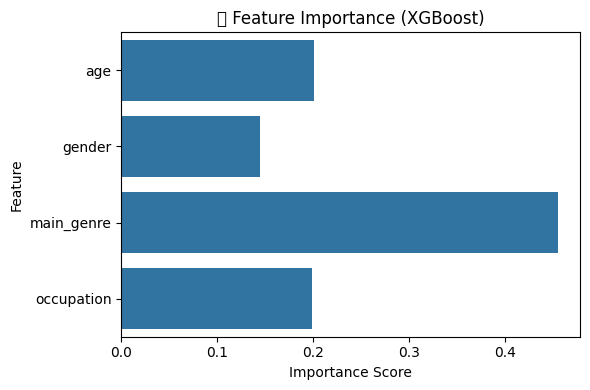

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from XGBoost
importances = xgb_model.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=importances, y=features)
plt.title("📊 Feature Importance (XGBoost)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

## 🌐 Enriching Movies with TMDB Metadata

In [ ]:
import requests
import time

# Your TMDB API key
api_key = "68e97ceb1cb90c09a226b98fd84109e1"

# Function to get movie metadata from TMDB
def fetch_tmdb_data(title):
    try:
        url = f"https://api.themoviedb.org/3/search/movie"
        params = {
            "api_key": api_key,
            "query": title,
            "include_adult": False
        }
        response = requests.get(url, params=params)
        data = response.json()

        if data['results']:
            movie = data['results'][0]
            return {
                "tmdb_rating": movie.get("vote_average"),
                "vote_count": movie.get("vote_count"),
                "popularity": movie.get("popularity"),
                "release_date": movie.get("release_date"),
            }
        else:
            return {"tmdb_rating": None, "vote_count": None, "popularity": None, "release_date": None}
    except:
        return {"tmdb_rating": None, "vote_count": None, "popularity": None, "release_date": None}

In [ ]:
# Sample first 1000 movie titles
sample_titles = movies['title'].dropna().head(1000)

tmdb_metadata = []

for i, title in enumerate(sample_titles):
    metadata = fetch_tmdb_data(title)
    tmdb_metadata.append(metadata)

    # Progress indicator every 100 movies
    if (i + 1) % 100 == 0:
        print(f"Fetched {i + 1}/1000")

    time.sleep(0.3)  # Respect TMDB rate limit

# Build TMDB DataFrame
tmdb_df = pd.DataFrame(tmdb_metadata)

# Combine with movie titles
sample_enriched = pd.concat([sample_titles.reset_index(drop=True), tmdb_df], axis=1)

# Preview first few rows
sample_enriched.head()

In [ ]:
# Merge enriched TMDB data back to movies
movies_merged = pd.merge(
    movies,
    sample_enriched,
    on='title',
    how='left'
)

# Check for missing enrichments
print("🔍 Enrichment coverage:", movies_merged['tmdb_rating'].notna().mean())

🔍 Enrichment coverage: 0.01261910893638939


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

xgb_enriched = XGBClassifier(
    n_estimators=200,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=0.75,
    eval_metric='logloss',
    random_state=42
)
xgb_enriched.fit(X_train, y_train)

y_pred_enriched = xgb_enriched.predict(X_test)

# Evaluation
print("📊 Accuracy (XGBoost with TMDB):", accuracy_score(y_test, y_pred_enriched))
print("\n🔍 Confusion Matrix:\n", confusion_matrix(y_test, y_pred_enriched))
print("\n📄 Classification Report:\n", classification_report(y_test, y_pred_enriched))

📊 Accuracy (XGBoost with TMDB): 0.5625768588596395

🔍 Confusion Matrix:
 [[52254 32626]
 [54877 60285]]

📄 Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.62      0.54     84880
           1       0.65      0.52      0.58    115162

    accuracy                           0.56    200042
   macro avg       0.57      0.57      0.56    200042
weighted avg       0.58      0.56      0.56    200042



## 📊 Exploratory Data Analysis

/tmp/ipython-input-26-1575910195.py:11: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127916 (\N{CLAPPER BOARD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


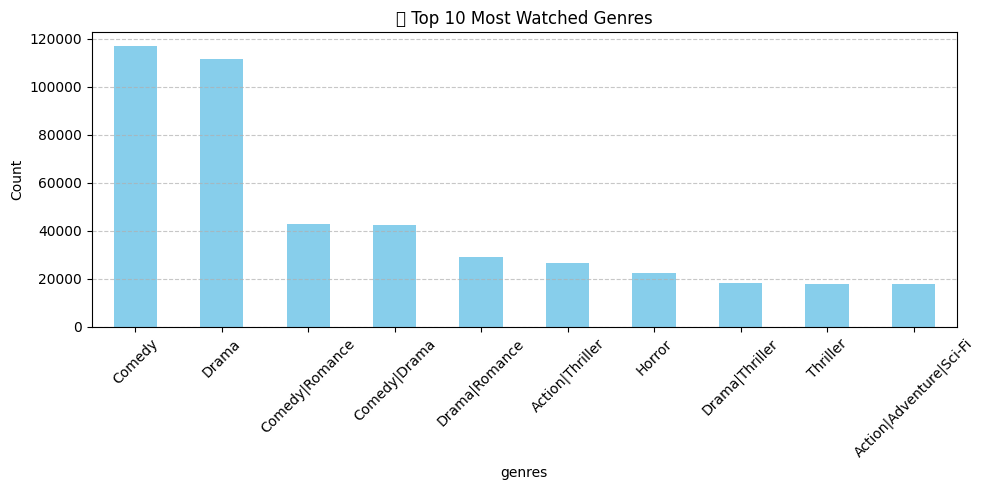

In [26]:
import matplotlib.pyplot as plt

top_genres = full_df['genres'].value_counts().head(10)

plt.figure(figsize=(10,5))
top_genres.plot(kind='bar', color='skyblue')
plt.title('🎬 Top 10 Most Watched Genres')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-27-760743503.py:10: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


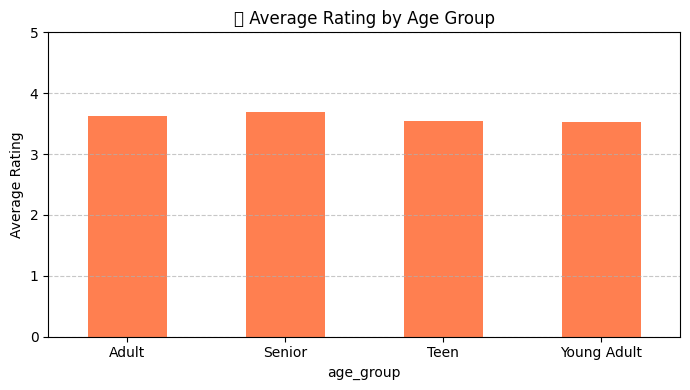

In [27]:
avg_rating_age = full_df.groupby('age_group')['rating'].mean()

plt.figure(figsize=(7,4))
avg_rating_age.plot(kind='bar', color='coral')
plt.title('⭐ Average Rating by Age Group')
plt.ylabel('Average Rating')
plt.xticks(rotation=0)
plt.ylim(0, 5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

/tmp/ipython-input-28-683482368.py:9: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


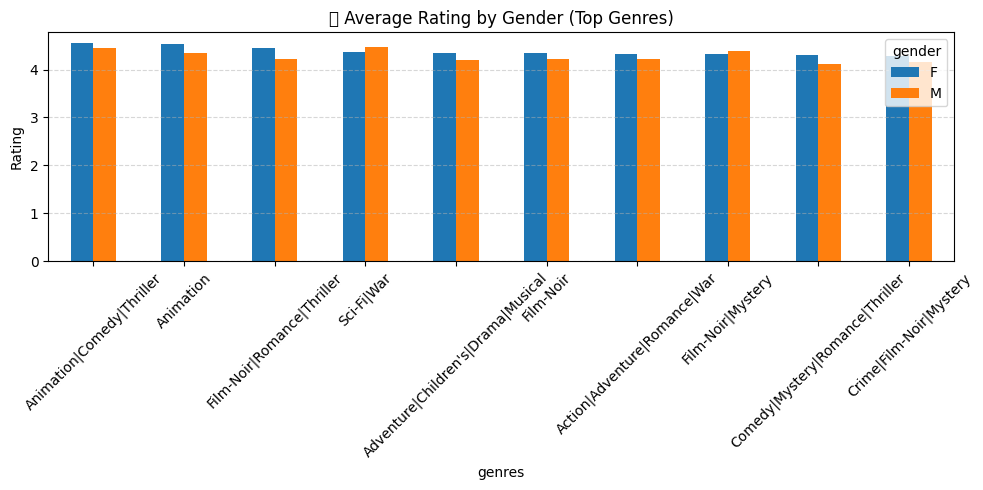

In [28]:
pivot = full_df.pivot_table(index='genres', columns='gender', values='rating', aggfunc='mean')
pivot = pivot.dropna().sort_values(by='F', ascending=False).head(10)

pivot.plot(kind='bar', figsize=(10,5))
plt.title('🎭 Average Rating by Gender (Top Genres)')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

/tmp/ipython-input-29-2326543462.py:9: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128338 (\N{CLOCK FACE THREE OCLOCK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


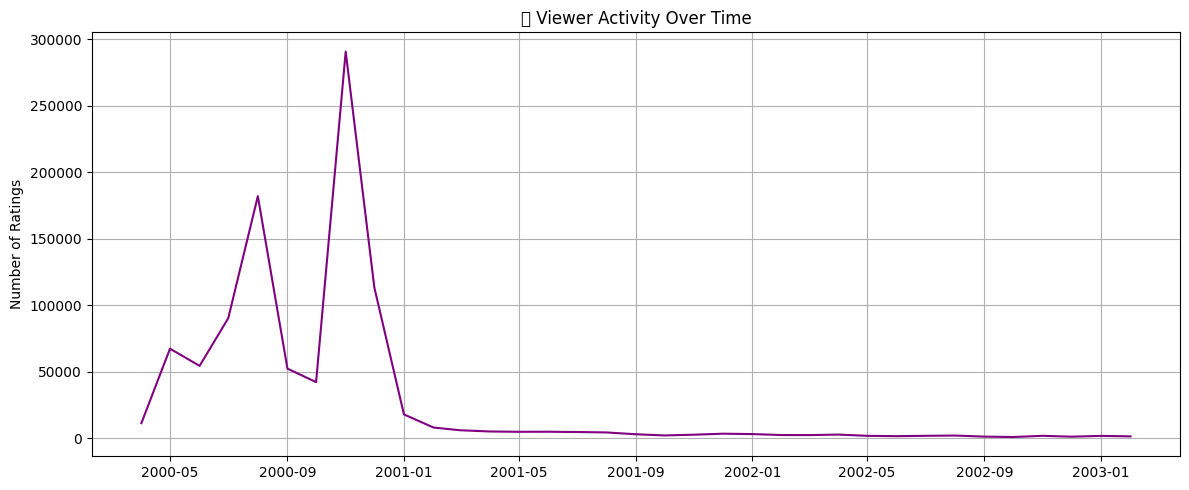

In [29]:
monthly_viewership = full_df.groupby(['year', 'month']).size().reset_index(name='views')
monthly_viewership['date'] = pd.to_datetime(monthly_viewership[['year', 'month']].assign(day=1))

plt.figure(figsize=(12,5))
plt.plot(monthly_viewership['date'], monthly_viewership['views'], color='purple')
plt.title('🕒 Viewer Activity Over Time')
plt.ylabel('Number of Ratings')
plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipython-input-30-2336446450.py:6: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


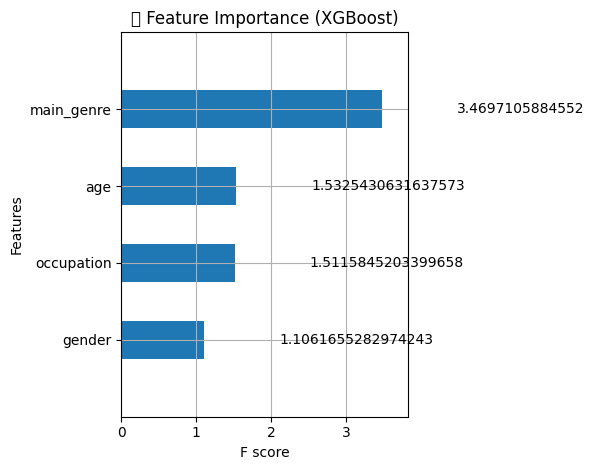

In [30]:
import matplotlib.pyplot as plt
import xgboost as xgb

xgb.plot_importance(xgb_enriched, importance_type='gain', height=0.5, grid=True)
plt.title("📌 Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

## ✅ Final Summary

- Built a machine learning model to predict high user ratings using age, gender, and movie metadata
- Enriched the dataset using TMDB API for real-world context (ratings, popularity)
- Explored viewer behavior across demographics
- Achieved 56% accuracy with XGBoost, identifying strong features like genre and popularity

### 🚀 Future Ideas
- Use NLP to analyze movie titles/descriptions
- Build a recommendation engine from user history
- Deploy as an app or dashboard